<a href="https://colab.research.google.com/github/nrajmalwar/Project/blob/master/Session%2018/Assignment_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition

1. dlib face detector
2. Align the face using 5 point detector
3. 68-pt landmark on aligned faces
4. Calculate Optical flow for these 68 points for every frame
5. Stabilize Optical Flow using LK method

# Detection and Tracking for Stabilization

In [0]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
from google.colab.patches import cv2_imshow
import cv2, dlib
import numpy as np
import math, sys

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int(xin), np.int(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
  tform = cv2.estimateAffinePartial2D(np.array([inPts]), np.array([outPts]))
  return tform[0]

In [0]:
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
  h, w = outSize

  # Corners of the eye in input image
  if len(pointsIn) == 68:
    eyecornerSrc = [pointsIn[36], pointsIn[45]]
  elif len(pointsIn) == 5:
    eyecornerSrc = [pointsIn[2], pointsIn[0]]

  # Corners of the eye in normalized image
  eyecornerDst = [(np.int(0.3 * w), np.int(h/3)),
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform, (w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn, 
                      (pointsIn.shape[0], 1, pointsIn.shape[1]))

  # Apply similarity transform to landmarks
  pointsOut = cv2.transform(points2, tform)

  # reshape pointsOut to numLandmarks x 2
  pointsOut = np.reshape(pointsOut, 
                          (pointsIn.shape[0], pointsIn.shape[1]))

  return imOut, pointsOut

In [0]:
MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/EVA/Session 18/"
PREDICTOR_PATH = MODEL_PATH + "shape_predictor_68_face_landmarks.dat"
PREDICTOR_PATH_2 = MODEL_PATH + "shape_predictor_5_face_landmarks.dat"
RESIZE_HEIGHT = 480
NUM_FRAMES_FOR_FPS = 100
SKIP_FRAMES = 1

In [0]:
# Function to calculate the intereye distance.
def interEyeDistance(predict):
  leftEyeLeftCorner = (predict[36].x, predict[36].y)
  rightEyeRightCorner = (predict[45].x, predict[45].y)
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

In [0]:
videoFileName = "/content/drive/My Drive/Colab Notebooks/EVA/Session 18/my_video3.mp4"

# Initializing video capture object.
cap = cv2.VideoCapture(videoFileName)

if(cap.isOpened()==False):
  print("Unable to load video")

Specifying the parameters of Lucas Kanade Method

In [0]:
# winName = "Stabilized facial landmark detector"
# winSize = 101
maxLevel = 10
fps = 30.0
# Grab a frame
ret, imPrev = cap.read()
# Finding the size of the image.
size = imPrev.shape[0:1]

In [0]:
faceDetector = dlib.get_frontal_face_detector()
landmarkDetector_68pt = dlib.shape_predictor(PREDICTOR_PATH)
landmarkDetector_5pt = dlib.shape_predictor(PREDICTOR_PATH_2)

In [0]:
# Initializing the parameters
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]
eyeDistanceNotCalculated = True
eyeDistance = 0
isFirstFrame = True
# Initial value, actual value calculated after 100 frames
fps = 10
showStabilized = False
count =0

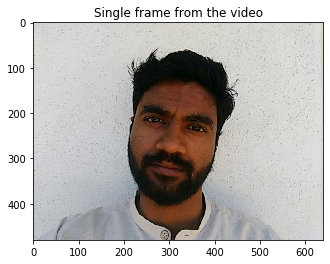

In [0]:
# Display the results
plt.imshow(imPrev[:,:,::-1])
plt.title("Single frame from the video")
plt.show()

# Run on the video file

In [0]:
fourcc = cv2.VideoWriter_fourcc(*'XVID') 
out = cv2.VideoWriter('output_aligned.avi', fourcc, 20.0, (640, 480))

In [0]:
import faceBlendCommon as fbc

In [0]:
while(True):
  if (count==0):
    t = cv2.getTickCount()

  # Grab a frame
  ret, im = cap.read()
  if ret == False:
    break

  # Detect 5 pt landmarks in current frame for face alignment
  points_5 = fbc.getLandmarks(faceDetector, landmarkDetector_5pt, im)
  points_5 = np.array(points_5)

  # Convert image to floating point in the range 0 to 1
  # im = np.float32(im)/255.0
  im, _ = fbc.normalizeImagesAndLandmarks((480, 640), im, points_5)
  # im = np.int8(im*255) 

  imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

  # Converting to grayscale
  imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  height = im.shape[0]
  IMAGE_RESIZE = float(height)/RESIZE_HEIGHT

  # Resize image for faster face detection
  imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
  imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)

  faces = faceDetector(imSmallDlib,0)

  # If no face was detected
  if len(faces)==0:
    print("No face detected")

  # If faces are detected, iterate through each image and detect landmark points
  else:
    for i in range(0,len(faces)):
      print("face detected")

      # Face detector was found over a smaller image.
      # So, we scale face rectangle to correct size.
      newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
        int(faces[i].top() * IMAGE_RESIZE),
        int(faces[i].right() * IMAGE_RESIZE),
        int(faces[i].bottom() * IMAGE_RESIZE))     


      # Detect 68 pt landmarks in current frame
      landmarks = landmarkDetector_68pt(imDlib, newRect).parts()

      # Handling the first frame of video differently,for the first frame copy the current frame points
      
      if (isFirstFrame==True):
        pointsPrev=[]
        imGrayPrev = imGray
        pointsDetectedPrev = []
        [pointsPrev.append((p.x, p.y)) for p in landmarks]
        [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]

      # If not the first frame, copy points from previous frame.
      else:
        pointsPrev=[]
        pointsDetectedPrev = []
        pointsPrev = points
        pointsDetectedPrev = pointsDetectedCur

      # pointsDetectedCur stores results returned by the facial landmark detector
      # points stores the stabilized landmark points
      points = []
      pointsDetectedCur = []
      [points.append((p.x, p.y)) for p in landmarks]
      [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

      # Convert to numpy float array
      pointsArr = np.array(points,np.float32)
      pointsPrevArr = np.array(pointsPrev,np.float32)

      # If eye distance is not calculated before
      if eyeDistanceNotCalculated:
        eyeDistance = interEyeDistance(landmarks)
        print(eyeDistance)
        eyeDistanceNotCalculated = False

      if eyeDistance > 100:
          dotRadius = 3
      else:
        dotRadius = 2

      print(eyeDistance)
      sigma = eyeDistance * eyeDistance / 400
      s = 2*int(eyeDistance/4)+1

      #  Set up optical flow params
      lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
      # Python Bug. Calculating pyramids and then calculating optical flow results in an error. So directly images are used.
      # ret, imGrayPyr= cv2.buildOpticalFlowPyramid(imGray, (winSize,winSize), maxLevel)

      pointsArr,status, err = cv2.calcOpticalFlowPyrLK(imGrayPrev,imGray,pointsPrevArr,pointsArr,**lk_params)
      

      # Converting to float
      pointsArrFloat = np.array(pointsArr,np.float32)

      # Converting back to list
      points = pointsArrFloat.tolist()

      # Final landmark points are a weighted average of
      # detected landmarks and tracked landmarks
      for k in range(0,len(landmarks)):
        d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
        alpha = math.exp(-d*d/sigma)
        points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

      # Drawing over the stabilized landmark points
      if showStabilized is True:
        for p in points:
          cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (255,0,0),-1)
      else:
        for p in pointsDetectedCur:
          cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (0,0,255),-1)

      isFirstFrame = False
      count = count+1

      # Calculating the fps value
      if ( count == NUM_FRAMES_FOR_FPS):
        t = (cv2.getTickCount()-t)/cv2.getTickFrequency()
        fps = NUM_FRAMES_FOR_FPS/t
        count = 0
        isFirstFrame = True

      # Display the landmarks points
      cv2.putText(im, "{:.1f}-fps".format(fps), (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3,cv2.LINE_AA)
      out.write(im) 

      imPrev = im
      imGrayPrev = imGray

# cv2.destroyAllwindows()
cap.release()
out.release()